<a href="https://colab.research.google.com/github/EmilyCarroll-del/Michael-J-Fox-Foundation-FOG-in-PD/blob/main/MJF_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/'
%ls

/content/drive/MyDrive/Colab Notebooks
'Copy of defog_start_hesitation.csv'          defog_turn_draft.csv
'Copy of defog_start_hesitation_test.csv'     defog_turn_test_draft.csv
'Copy of defog_turn.csv'                      defog_walk_draft.csv
'Copy of defog_turn_test.csv'                 defog_walk_test_draft.csv
'Copy of defog_walking.csv'                   MJFF-FOG-Prediction-PD.ipynb
'Copy of defog_walking_test.csv'              tdcsfog_sh_draft.csv
'Copy of tdcsfog_start_hesitation.csv'        tdcsfog_sh_test_draft.csv
'Copy of tdcsfog_start_hesitation_test.csv'   tdcsfog_turn_draft.csv
'Copy of tdcsfog_turn.csv'                    tdcsfog_turn_test_draft.csv
'Copy of tdcsfog_turn_test.csv'               tdcsfog_walk_draft.csv
'Copy of tdcsfog_walking.csv'                 tdcsfog_walk_test_draft.csv
'Copy of tdcsfog_walking_test.csv'            Test/
 defog_sh_draft.csv                           tlvmc-parkinsons-freezing-gait-prediction/
 defog_sh_test_draft.csv


In [ ]:
!pip install tsflex seglearn tensorflow Keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_feature_dict_wrapper
from seglearn.feature_functions import base_features, emg_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
def process_directory(directory):
    dfs = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)

        # Check if the file is a CSV and process it
        if file_name.endswith('.csv') and os.path.isfile(file_path):
            df = pd.read_csv(file_path) #read csv files
            df['source_directory'] = os.path.basename(directory)  # Add a column to identify the source directory
            df['csv_name'] = os.path.basename(file_name)
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

In [ ]:
defog = process_directory('/content/drive/MyDrive/Colab Notebooks/tlvmc-parkinsons-freezing-gait-prediction/train/defog')
tdcsfog = process_directory('/content/drive/MyDrive/Colab Notebooks/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog')
#notype = process_directory('/content/drive/MyDrive/Colab Notebooks/tlvmc-parkinsons-freezing-gait-prediction/train/notype')

In [ ]:
#defog_test = process_directory('/content/drive/MyDrive/Colab Notebooks/tlvmc-parkinsons-freezing-gait-prediction/test/defog')

In [ ]:
folder_path = "/content/drive/My Drive/Colab Notebooks/Test"
file_name = "Copy of 3e6987cb2d.csv"
file_path = os.path.join(folder_path, file_name)
defog_test = pd.read_csv(file_path)
defog_test.shape

(300288, 9)

In [ ]:
folder_path = "/content/drive/My Drive/Colab Notebooks/Test"
file_name = "Copy of 3ba3590a08.csv"
file_path = os.path.join(folder_path, file_name)
tdcsfog_test = pd.read_csv(file_path)
tdcsfog_test.shape

(46817, 7)

In [ ]:
turn_count = defog_test['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = defog_test['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = defog_test['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

Number of values that are 1 in the 'Turn' column: 33881
Number of values that are 1 in the 'Walking' column: 741
Number of values that are 1 in the 'StartHesitation' column: 0


In [ ]:
turn_count = tdcsfog_test['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = tdcsfog_test['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = tdcsfog_test['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

Number of values that are 1 in the 'Turn' column: 27743
Number of values that are 1 in the 'Walking' column: 4285
Number of values that are 1 in the 'StartHesitation' column: 11459


In [ ]:
print('defog rows:', defog.shape[0]) #13.5 million
print('tdcsfog rows:', tdcsfog.shape[0]) #7 million

defog rows: 13225414
tdcsfog rows: 7015855


In [ ]:
turn_count = defog['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = defog['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = defog['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

no_turn_count = defog['Turn'].value_counts().get(0, 0)
print(f"Number of values that are 0 in the 'Turn' column: {no_turn_count}")

no_walking_count = defog['Walking'].value_counts().get(0, 0)
print(f"Number of values that are 0 in the 'Walking' column: {no_walking_count}")

no_sh_count = defog['StartHesitation'].value_counts().get(0, 0)
print(f"Number of values that are 0 in the 'StartHesitation' column: {no_sh_count}")

Number of values that are 1 in the 'Turn' column: 553605
Number of values that are 1 in the 'Walking' column: 97778
Number of values that are 1 in the 'StartHesitation' column: 500
Number of values that are 0 in the 'Turn' column: 12671809
Number of values that are 0 in the 'Walking' column: 13127636
Number of values that are 0 in the 'StartHesitation' column: 13224914


In [ ]:
turn_count = tdcsfog['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = tdcsfog['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = tdcsfog['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

no_turn_count = tdcsfog['Turn'].value_counts().get(0, 0)
print(f"Number of values that are 0 in the 'Turn' column: {no_turn_count}")

no_walking_count = tdcsfog['Walking'].value_counts().get(0, 0)
print(f"Number of values that are 0 in the 'Walking' column: {no_walking_count}")

no_sh_count = tdcsfog['StartHesitation'].value_counts().get(0, 0)
print(f"Number of values that are 0 in the 'StartHesitation' column: {no_sh_count}")

Number of values that are 1 in the 'Turn' column: 1651039
Number of values that are 1 in the 'Walking' column: 203553
Number of values that are 1 in the 'StartHesitation' column: 293331
Number of values that are 0 in the 'Turn' column: 5364816
Number of values that are 0 in the 'Walking' column: 6812302
Number of values that are 0 in the 'StartHesitation' column: 6722524


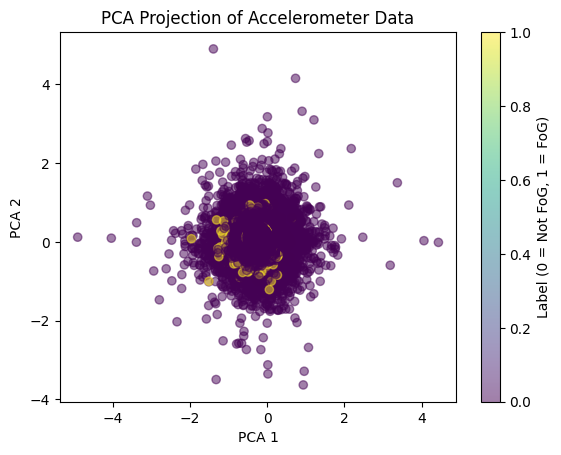

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = defog[['AccV', 'AccML', 'AccAP']]
y = defog['Turn']  # 0 for walking, 1 for stopping

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.title("PCA Projection of Accelerometer Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Label (0 = Not FoG, 1 = FoG)")
plt.show()

In [ ]:
#removing missing values

#defog dataset, valid = false, task = false
#tdcsfog has no missing values
defog = defog[defog['Valid']]
defog = defog[defog['Task']]

In [ ]:
#drop a small amount of outliers -defog

from scipy.stats import zscore

# Calculate z-scores for each accelerometer axis
defog["AccV_z"] = zscore(defog["AccV"])
defog["AccML_z"] = zscore(defog["AccML"])
defog["AccAP_z"] = zscore(defog["AccAP"])

# Set threshold range for z-scores (-5 < z < 5)
threshold = 5

# Find rows where any component exceeds the threshold
outliers = (defog["AccV_z"].abs() > threshold) | \
           (defog["AccML_z"].abs() > threshold) | \
           (defog["AccAP_z"].abs() > threshold)

# Filter out these rows from the dataset
defog = defog[~outliers].drop(columns=["AccV_z", "AccML_z", "AccAP_z"])

# Save or inspect the filtered DataFrame
print("Number of points dropped:", outliers.sum())
print(defog.head())

Number of points dropped: 11644
      Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
1000  1000 -0.970018  0.061626 -0.265625                0     0        0   
1001  1001 -0.984375  0.044497 -0.265625                0     0        0   
1002  1002 -0.984375  0.029016 -0.265625                0     0        0   
1003  1003 -0.984375  0.015625 -0.265625                0     0        0   
1004  1004 -0.984670  0.015330 -0.265625                0     0        0   

      Valid  Task source_directory        csv_name  
1000   True  True            defog  02ea782681.csv  
1001   True  True            defog  02ea782681.csv  
1002   True  True            defog  02ea782681.csv  
1003   True  True            defog  02ea782681.csv  
1004   True  True            defog  02ea782681.csv  


In [ ]:
#drop a small amount of outliers -tdcsfog

# Calculate z-scores for each accelerometer axis
tdcsfog["AccV_z"] = zscore(tdcsfog["AccV"])
tdcsfog["AccML_z"] = zscore(tdcsfog["AccML"])
tdcsfog["AccAP_z"] = zscore(tdcsfog["AccAP"])

# Set threshold range for z-scores (-5 < z < 5)
threshold = 5

# Find rows where any component exceeds the threshold
outliers = (tdcsfog["AccV_z"].abs() > threshold) | \
           (tdcsfog["AccML_z"].abs() > threshold) | \
           (tdcsfog["AccAP_z"].abs() > threshold)

# Filter out these rows from the dataset
tdcsfog = tdcsfog[~outliers].drop(columns=["AccV_z", "AccML_z", "AccAP_z"])

# Save or inspect the filtered DataFrame
print("Number of points dropped:", outliers.sum())
print(tdcsfog.head())

Number of points dropped: 27184
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
0     0 -9.533939  0.566322 -1.413525                0     0        0   
1     1 -9.536140  0.564137 -1.440621                0     0        0   
2     2 -9.529345  0.561765 -1.429332                0     0        0   
3     3 -9.531239  0.564227 -1.415490                0     0        0   
4     4 -9.540825  0.561854 -1.429471                0     0        0   

  source_directory        csv_name  
0          tdcsfog  003f117e14.csv  
1          tdcsfog  003f117e14.csv  
2          tdcsfog  003f117e14.csv  
3          tdcsfog  003f117e14.csv  
4          tdcsfog  003f117e14.csv  


In [ ]:
#filter the accelerometer data - defog

from scipy.signal import butter, filtfilt

fs = 100  # Sampling frequency in Hz

# Define filter parameters
lowcut = 0.25
highcut = 10.0
order = 4  # Filter order

# Create a Butterworth bandpass filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype="band")

# Apply the filter to each accelerometer axis
defog["AccV_filtered"] = filtfilt(b, a, defog["AccV"])
defog["AccML_filtered"] = filtfilt(b, a, defog["AccML"])
defog["AccAP_filtered"] = filtfilt(b, a, defog["AccAP"])

print(defog.head())

      Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
1000  1000 -0.970018  0.061626 -0.265625                0     0        0   
1001  1001 -0.984375  0.044497 -0.265625                0     0        0   
1002  1002 -0.984375  0.029016 -0.265625                0     0        0   
1003  1003 -0.984375  0.015625 -0.265625                0     0        0   
1004  1004 -0.984670  0.015330 -0.265625                0     0        0   

      Valid  Task source_directory        csv_name  AccV_filtered  \
1000   True  True            defog  02ea782681.csv      -0.002409   
1001   True  True            defog  02ea782681.csv      -0.008514   
1002   True  True            defog  02ea782681.csv      -0.014268   
1003   True  True            defog  02ea782681.csv      -0.019375   
1004   True  True            defog  02ea782681.csv      -0.023621   

      AccML_filtered  AccAP_filtered  
1000       -0.028097        0.003932  
1001       -0.043759        0.003981  
1002       

In [ ]:
# Plotting the original and filtered signals for comparison - defog
plt.figure(figsize=(12, 6))

# Plot for AccV (Vertical Acceleration)
plt.subplot(3, 1, 1)
plt.plot(defog["Time"], defog["AccV"], label='Original AccV', alpha=0.5)
plt.plot(defog["Time"], defog["AccV_filtered"], label='Filtered AccV', color='red')
plt.title("Vertical Acceleration (AccV)")
plt.legend()

# Plot for AccML (Medial-Lateral Acceleration)
plt.subplot(3, 1, 2)
plt.plot(defog["Time"], defog["AccML"], label='Original AccML', alpha=0.5)
plt.plot(defog["Time"], defog["AccML_filtered"], label='Filtered AccML', color='green')
plt.title("Medial-Lateral Acceleration (AccML)")
plt.legend()

# Plot for AccAP (Anterior-Posterior Acceleration)
plt.subplot(3, 1, 3)
plt.plot(defog["Time"], defog["AccAP"], label='Original AccAP', alpha=0.5)
plt.plot(defog["Time"], defog["AccAP_filtered"], label='Filtered AccAP', color='blue')
plt.title("Anterior-Posterior Acceleration (AccAP)")
plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x78d7fb1424d0> (for post_execute):


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x78d7fb1411b0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
#filter the accelerometer data - tdcsfog

from scipy.signal import butter, filtfilt

fs = 128  # Sampling frequency in Hz

# Define filter parameters
lowcut = 0.25
highcut = 10.0
order = 4  # Filter order

# Create a Butterworth bandpass filter
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(order, [low, high], btype="band")

# Apply the filter to each accelerometer axis
tdcsfog["AccV_filtered"] = filtfilt(b, a, tdcsfog["AccV"])
tdcsfog["AccML_filtered"] = filtfilt(b, a, tdcsfog["AccML"])
tdcsfog["AccAP_filtered"] = filtfilt(b, a, tdcsfog["AccAP"])

print(tdcsfog.head())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking  \
0     0 -9.533939  0.566322 -1.413525                0     0        0   
1     1 -9.536140  0.564137 -1.440621                0     0        0   
2     2 -9.529345  0.561765 -1.429332                0     0        0   
3     3 -9.531239  0.564227 -1.415490                0     0        0   
4     4 -9.540825  0.561854 -1.429471                0     0        0   

  source_directory        csv_name  AccV_filtered  AccML_filtered  \
0          tdcsfog  003f117e14.csv       0.001085        0.000976   
1          tdcsfog  003f117e14.csv       0.000987       -0.000830   
2          tdcsfog  003f117e14.csv       0.000909       -0.002732   
3          tdcsfog  003f117e14.csv       0.000867       -0.004787   
4          tdcsfog  003f117e14.csv       0.000862       -0.006999   

   AccAP_filtered  
0        0.006895  
1        0.003351  
2        0.000218  
3       -0.002184  
4       -0.003691  


<ipython-input-45-ba9422770a80>:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


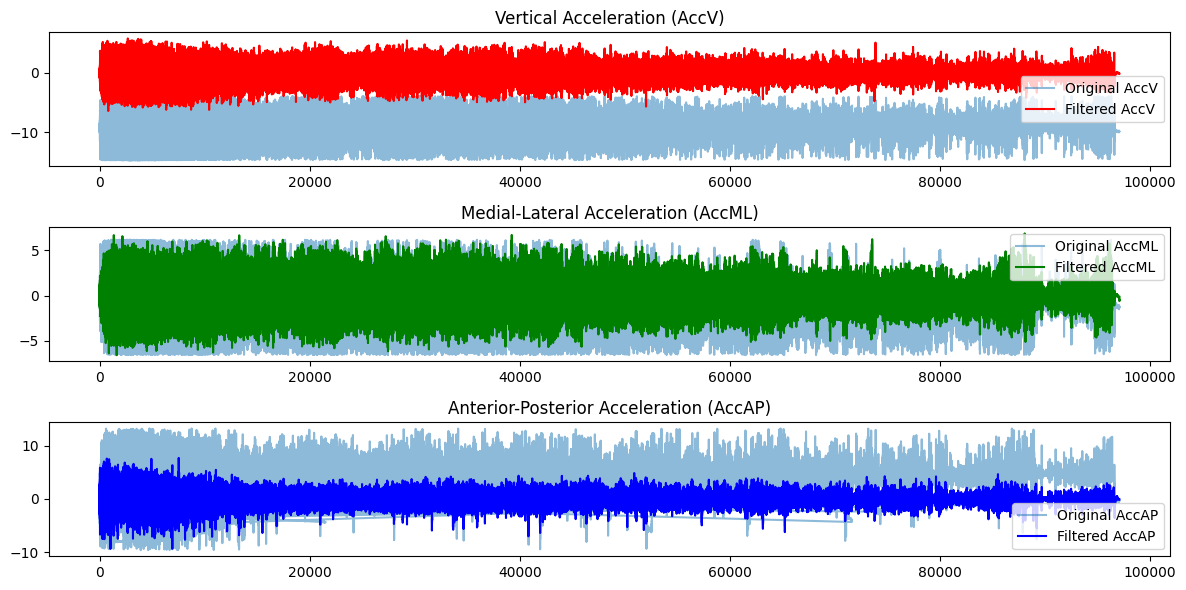

In [ ]:
# Plotting the original and filtered signals for comparison - tdcsfog
plt.figure(figsize=(12, 6))

# Plot for AccV (Vertical Acceleration)
plt.subplot(3, 1, 1)
plt.plot(tdcsfog["Time"], tdcsfog["AccV"], label='Original AccV', alpha=0.5)
plt.plot(tdcsfog["Time"], tdcsfog["AccV_filtered"], label='Filtered AccV', color='red')
plt.title("Vertical Acceleration (AccV)")
plt.legend()

# Plot for AccML (Medial-Lateral Acceleration)
plt.subplot(3, 1, 2)
plt.plot(tdcsfog["Time"], tdcsfog["AccML"], label='Original AccML', alpha=0.5)
plt.plot(tdcsfog["Time"], tdcsfog["AccML_filtered"], label='Filtered AccML', color='green')
plt.title("Medial-Lateral Acceleration (AccML)")
plt.legend()

# Plot for AccAP (Anterior-Posterior Acceleration)
plt.subplot(3, 1, 3)
plt.plot(tdcsfog["Time"], tdcsfog["AccAP"], label='Original AccAP', alpha=0.5)
plt.plot(tdcsfog["Time"], tdcsfog["AccAP_filtered"], label='Filtered AccAP', color='blue')
plt.title("Anterior-Posterior Acceleration (AccAP)")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
defog = defog.drop(columns=['AccV', 'AccML', 'AccAP'])
tdcsfog = tdcsfog.drop(columns=['AccV', 'AccML', 'AccAP'])

In [ ]:
defog = defog.reset_index(drop=True)
tdcsfog = tdcsfog.reset_index(drop=True)

In [ ]:
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import AllKNN
from collections import Counter

#Oversampling then undersampling for DEFOG - TURN
X = defog[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered']]
y = defog['Turn']

# Step 1: Oversample using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_smote))

# Step 2: Undersample using AllKNN
all_knn = AllKNN()
X_resampled, y_resampled = all_knn.fit_resample(X_smote, y_smote)
print("Class distribution after AllKNN:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 3397113, 1: 1698556})
Class distribution after AllKNN: Counter({0: 1879559, 1: 1698556})


In [ ]:
re_defog_turn = pd.DataFrame(X_resampled, columns=X.columns)  # Use the same column names as original
re_defog_turn['Turn'] = y_resampled  # Add the target column back

# Display the resampled DataFrame
print(re_defog_turn.head())
print(re_defog_turn.shape)

   AccV_filtered  AccML_filtered  AccAP_filtered  Turn
0      -0.014268       -0.057533        0.004027     0
1      -0.029128       -0.078256        0.004108     0
2      -0.030671       -0.081719        0.004392     0
3      -0.030555       -0.083916        0.004560     0
4      -0.030452       -0.085527        0.004715     0
(3578115, 4)


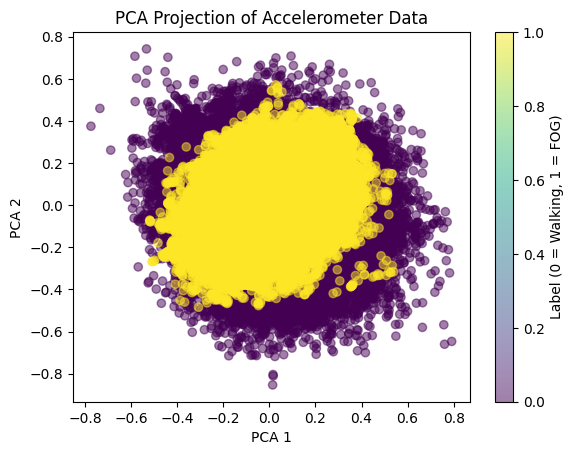

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot the data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title("PCA Projection of Accelerometer Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Label (0 = Walking, 1 = FOG)")
plt.show()

In [ ]:
#Oversampling then undersampling for DEFOG - Walking
X = defog[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered']]
y = defog['Walking']

# Step 1: Oversample using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_smote))

# Step 2: Undersample using AllKNN
all_knn = AllKNN()
X_resampled, y_resampled = all_knn.fit_resample(X_smote, y_smote)
print("Class distribution after AllKNN:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 3852062, 1: 1926031})
Class distribution after AllKNN: Counter({0: 3350427, 1: 1926031})


In [ ]:
re_defog_walk = pd.DataFrame(X_resampled, columns=X.columns)  # Use the same column names as original
re_defog_walk['Walking'] = y_resampled  # Add the target column back

# Display the resampled DataFrame
print(re_defog_walk.head())
print(re_defog_walk.shape)

   AccV_filtered  AccML_filtered  AccAP_filtered  Walking
0      -0.002409       -0.028097        0.003932        0
1      -0.008514       -0.043759        0.003981        0
2      -0.014268       -0.057533        0.004027        0
3      -0.019375       -0.068014        0.004066        0
4      -0.023621       -0.074621        0.004092        0
(5276458, 4)


In [ ]:
#Oversampling then undersampling for DEFOG - Start Hesitation
X = defog[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered']]
y = defog['StartHesitation']

# Step 1: Oversample using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_smote))

# Step 2: Undersample using AllKNN
all_knn = AllKNN()
X_resampled, y_resampled = all_knn.fit_resample(X_smote, y_smote)
print("Class distribution after AllKNN:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 3949298, 1: 1974649})
Class distribution after AllKNN: Counter({0: 3947475, 1: 1974649})


In [ ]:
re_defog_sh = pd.DataFrame(X_resampled, columns=X.columns)  # Use the same column names as original
re_defog_sh['StartHesitation'] = y_resampled  # Add the target column back

# Display the resampled DataFrame
print(re_defog_sh.head())
print(re_defog_sh.shape)

   AccV_filtered  AccML_filtered  AccAP_filtered  StartHesitation
0      -0.002409       -0.028097        0.003932                0
1      -0.008514       -0.043759        0.003981                0
2      -0.014268       -0.057533        0.004027                0
3      -0.019375       -0.068014        0.004066                0
4      -0.023621       -0.074621        0.004092                0
(5922124, 4)


In [ ]:
#Oversampling then undersampling for TDCSFOG - Turn
X = tdcsfog[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered']]
y = tdcsfog['Turn']

# Step 1: Oversample using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_smote))

# Step 2: Undersample using AllKNN
all_knn = AllKNN()
X_resampled, y_resampled = all_knn.fit_resample(X_smote, y_smote)
print("Class distribution after AllKNN:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 5343901, 1: 2671950})
Class distribution after AllKNN: Counter({1: 2671950, 0: 2209466})


In [ ]:
re_tdcsfog_turn = pd.DataFrame(X_resampled, columns=X.columns)  # Use the same column names as original
re_tdcsfog_turn['Turn'] = y_resampled  # Add the target column back

# Display the resampled DataFrame
print(re_tdcsfog_turn.head())
print(re_tdcsfog_turn.shape)

   AccV_filtered  AccML_filtered  AccAP_filtered  Turn
0       0.001085        0.000976        0.006895     0
1       0.000987       -0.000830        0.003351     0
2       0.000909       -0.002732        0.000218     0
3       0.000867       -0.004787       -0.002184     0
4       0.000862       -0.006999       -0.003691     0
(4881416, 4)


In [ ]:
#Oversampling then undersampling for DEFOG - Walking
X = tdcsfog[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered']]
y = tdcsfog['Walking']

# Step 1: Oversample using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_smote))

# Step 2: Undersample using AllKNN
all_knn = AllKNN()
X_resampled, y_resampled = all_knn.fit_resample(X_smote, y_smote)
print("Class distribution after AllKNN:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 6786417, 1: 3393208})
Class distribution after AllKNN: Counter({0: 5752147, 1: 3393208})


In [ ]:
re_tdcsfog_walk = pd.DataFrame(X_resampled, columns=X.columns)  # Use the same column names as original
re_tdcsfog_walk['Walking'] = y_resampled  # Add the target column back

# Display the resampled DataFrame
print(re_tdcsfog_walk.head())
print(re_tdcsfog_walk.shape)

   AccV_filtered  AccML_filtered  AccAP_filtered  Walking
0       0.001085        0.000976        0.006895        0
1       0.000987       -0.000830        0.003351        0
2       0.000909       -0.002732        0.000218        0
3       0.000867       -0.004787       -0.002184        0
4       0.000862       -0.006999       -0.003691        0
(9145355, 4)


In [ ]:
#Oversampling then undersampling for DEFOG - Start Hesitation
X = tdcsfog[['AccV_filtered', 'AccML_filtered', 'AccAP_filtered']]
y = tdcsfog['StartHesitation']

# Step 1: Oversample using BorderlineSMOTE
smote = BorderlineSMOTE(sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_smote))

# Step 2: Undersample using AllKNN
all_knn = AllKNN()
X_resampled, y_resampled = all_knn.fit_resample(X_smote, y_smote)
print("Class distribution after AllKNN:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 6696035, 1: 3348017})
Class distribution after AllKNN: Counter({0: 5316947, 1: 3348017})


In [ ]:
re_tdcsfog_sh = pd.DataFrame(X_resampled, columns=X.columns)  # Use the same column names as original
re_tdcsfog_sh['StartHesitation'] = y_resampled  # Add the target column back

# Display the resampled DataFrame
print(re_tdcsfog_sh.head())
print(re_tdcsfog_sh.shape)

   AccV_filtered  AccML_filtered  AccAP_filtered  StartHesitation
0       0.001085        0.000976        0.006895                0
1       0.000987       -0.000830        0.003351                0
2       0.000909       -0.002732        0.000218                0
3       0.000867       -0.004787       -0.002184                0
4       0.000862       -0.006999       -0.003691                0
(8664964, 4)


In [ ]:
#extract TIME and FREQUENCY-DOMAIN FEATURES for DEFOG
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[300],
    strides=[100],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[300],
    strides=[100]
)

fc_based = FeatureCollection([basic_feats])
fc_emgd = FeatureCollection([emg_feats])

In [ ]:
#extract TIME and FREQUENCY-DOMAIN FEATURES for TDCSFOG
basic_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(base_features()),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[384],
    strides=[128],
)

emg_feats = emg_features()
del emg_feats['simple square integral'] # is same as abs_energy (which is in base_features)

emg_feats = MultipleFeatureDescriptors(
    functions=seglearn_feature_dict_wrapper(emg_feats),
    series_names=['AccV_filtered', 'AccML_filtered', 'AccAP_filtered'],
    windows=[384],
    strides=[128]
)

fc_baset = FeatureCollection([basic_feats])
fc_emgt = FeatureCollection([emg_feats])

In [ ]:
#calculate features - DEFOG TURN
defog_base_turn = fc_based.calculate(re_defog_turn, return_df=True)
defog_emg_turn = fc_emgd.calculate(re_defog_turn, return_df=True)

#reset index
defog_base_turn = defog_base_turn.reset_index(drop=True)
defog_emg_turn = defog_emg_turn.reset_index(drop=True)

#concatenate
defog_turn = pd.concat([defog_base_turn, defog_emg_turn], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__mean__w=300'] in [1.1430038220005372 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__abs_energy__w=300'] in [0.5477240500003973 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__median__w=300'] in [2.9760240159994282 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__std__w=300'] in [2.4654875240003093 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [300, ('100',)]

In [ ]:
#calculate features - DEFOG Walking
defog_base_walk = fc_based.calculate(re_defog_walk, return_df=True)
defog_emg_walk = fc_emgd.calculate(re_defog_walk, return_df=True)

#reset index
defog_base_walk = defog_base_walk.reset_index(drop=True)
defog_emg_walk = defog_emg_walk.reset_index(drop=True)

#concatenate
defog_walk = pd.concat([defog_base_walk, defog_emg_walk], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__mean__w=300'] in [2.3955651619999117 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__abs_energy__w=300'] in [1.4459371889997783 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__median__w=300'] in [6.524717525000597 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__std__w=300'] in [3.9722564940002485 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [300, ('100',)] 

In [ ]:
#calculate features - DEFOG Start Hesitation
defog_base_sh = fc_based.calculate(re_defog_sh, return_df=True)
defog_emg_sh = fc_emgd.calculate(re_defog_sh, return_df=True)

#reset index
defog_base_sh = defog_base_sh.reset_index(drop=True)
defog_emg_sh = defog_emg_sh.reset_index(drop=True)

#concatenate
defog_sh = pd.concat([defog_base_sh, defog_emg_sh], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__mean__w=300'] in [2.081913875999817 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__abs_energy__w=300'] in [0.9255822719997013 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__median__w=300'] in [5.144038327000089 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [300, ('100',)] with output ['AccV_filtered__std__w=300'] in [5.200094726000316 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [300, ('100',)] wi

In [ ]:
#calculate features - TDCSFOG TURN
tdcsfog_base_turn = fc_baset.calculate(re_tdcsfog_turn, return_df=True)
tdcsfog_emg_turn = fc_emgt.calculate(re_tdcsfog_turn, return_df=True)

#reset index
tdcsfog_base_turn = tdcsfog_base_turn.reset_index(drop=True)
tdcsfog_emg_turn = tdcsfog_emg_turn.reset_index(drop=True)

#concatenate
tdcsfog_turn = pd.concat([tdcsfog_base_turn, tdcsfog_emg_turn], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__mean__w=384'] in [1.2749303480004528 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__abs_energy__w=384'] in [0.5556070539996654 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__median__w=384'] in [3.294359376999637 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__std__w=384'] in [2.643580760999612 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [384, ('128',)] w

In [ ]:
#calculate features - TDCSFOG Walking
tdcsfog_base_walk = fc_baset.calculate(re_tdcsfog_walk, return_df=True)
tdcsfog_emg_walk = fc_emgt.calculate(re_tdcsfog_walk, return_df=True)

#reset index
tdcsfog_base_walk = tdcsfog_base_walk.reset_index(drop=True)
tdcsfog_emg_walk = tdcsfog_emg_walk.reset_index(drop=True)

#concatenate
tdcsfog_walk = pd.concat([tdcsfog_base_walk, tdcsfog_emg_walk], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__mean__w=384'] in [2.4381358989994624 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__abs_energy__w=384'] in [1.049142178000693 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__median__w=384'] in [6.218253080000068 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__std__w=384'] in [4.971954945000107 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [384, ('128',)] wi

In [ ]:
#calculate features - TDCSFOG Start Hesitation
tdcsfog_base_sh = fc_baset.calculate(re_tdcsfog_sh, return_df=True)
tdcsfog_emg_sh = fc_emgt.calculate(re_tdcsfog_sh, return_df=True)

#reset index
tdcsfog_base_sh = tdcsfog_base_sh.reset_index(drop=True)
tdcsfog_emg_sh = tdcsfog_emg_sh.reset_index(drop=True)

#concatenate
tdcsfog_sh = pd.concat([tdcsfog_base_sh, tdcsfog_emg_sh], axis=1)

INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__mean] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__mean__w=384'] in [2.2732777050005097 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__abs_energy] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__abs_energy__w=384'] in [1.1315011580009013 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__median] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__median__w=384'] in [5.912512926999625 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__std] on [('AccV_filtered',)] with window-stride [384, ('128',)] with output ['AccV_filtered__std__w=384'] in [4.700219651000225 seconds]!
INFO:feature_calculation_logger:Finished function [[seglearn_wrapped]__minimum] on [('AccV_filtered',)] with window-stride [384, ('128',)] w

In [ ]:
defog_turn.to_csv('/content/drive/My Drive/Colab Notebooks/defog_turn_draft.csv')

In [ ]:
defog_walk.to_csv('/content/drive/My Drive/Colab Notebooks/defog_walk_draft.csv')

In [ ]:
defog_sh.to_csv('/content/drive/My Drive/Colab Notebooks/defog_sh_draft.csv')

In [ ]:
tdcsfog_turn.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_turn_draft.csv')

In [ ]:
tdcsfog_walk.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_walk_draft.csv')

In [ ]:
tdcsfog_sh.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_sh_draft.csv')

In [ ]:
defog_turn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/defog_turn_draft.csv')
defog_walk = pd.read_csv('/content/drive/My Drive/Colab Notebooks/defog_walk_draft.csv')
defog_sh = pd.read_csv('/content/drive/My Drive/Colab Notebooks/defog_sh_draft.csv')

tdcsfog_turn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_turn_draft.csv')
tdcsfog_walk = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_walk_draft.csv')
tdcsfog_sh = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_sh_draft.csv')

In [ ]:
#FOR DEFOG TURN

aggregated_labels = []

# Window size and stride size for the 100 Hz data
window_size = 300  # 3 seconds = 300 samples
stride_size = 100  # 1 second = 100 samples

# Iterate through the original high-frequency labels (re_defog_turn)
for start in range(0, len(re_defog_turn['Turn']) - window_size + 1, stride_size):
    # Extract the labels for the current window
    window_labels = re_defog_turn['Turn'][start:start + window_size]

    # Aggregation method: Majority voting
    aggregated_label = np.bincount(window_labels).argmax()

    # Append the aggregated label to the list
    aggregated_labels.append(aggregated_label)

# Convert to DataFrame
aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

# OPTIONAL: If you want to align this to your defog_turn DataFrame
# Ensure lengths of both match
if len(aggregated_labels) != len(defog_turn):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
defog_turn['Turn'] = aggregated_labels

In [ ]:
#DEFOG WALKING
aggregated_labels = []

window_size = 300  # 3 seconds = 300 samples
stride_size = 100  # 1 second = 100 samples

for start in range(0, len(re_defog_walk['Walking']) - window_size + 1, stride_size):
    window_labels = re_defog_walk['Walking'][start:start + window_size]

    # Aggregation method: Majority voting
    aggregated_label = np.bincount(window_labels).argmax()
    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(defog_walk):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
defog_walk['Walking'] = aggregated_labels

In [ ]:
#DEFOG START HESITATION
aggregated_labels = []

window_size = 300  # 3 seconds = 300 samples
stride_size = 100  # 1 second = 100 samples

for start in range(0, len(re_defog_sh['StartHesitation']) - window_size + 1, stride_size):
    window_labels = re_defog_sh['StartHesitation'][start:start + window_size]

    # Aggregation method: Majority voting
    aggregated_label = np.bincount(window_labels).argmax()
    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(defog_sh):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
defog_sh['StartHesitation'] = aggregated_labels

In [ ]:
print(defog_turn.shape)
print(defog_walk.shape)
print(defog_sh.shape)

(35779, 58)
(52762, 58)
(59219, 58)


In [ ]:
turn_count = defog_turn['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = defog_walk['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = defog_sh['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

Number of values that are 1 in the 'Turn' column: 16984
Number of values that are 1 in the 'Walking' column: 19259
Number of values that are 1 in the 'StartHesitation' column: 19745


In [ ]:
#TDCSFOG TURN
aggregated_labels = []

window_size = 384
stride_size = 128

for start in range(0, len(re_tdcsfog_turn['Turn']) - window_size + 1, stride_size):
    window_labels = re_tdcsfog_turn['Turn'][start:start + window_size]

    # Aggregation method: Majority voting
    aggregated_label = np.bincount(window_labels).argmax()
    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(tdcsfog_turn):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
tdcsfog_turn['Turn'] = aggregated_labels

In [ ]:
#TDCSFOG WALKING
aggregated_labels = []

window_size = 384
stride_size = 128

for start in range(0, len(re_tdcsfog_walk['Walking']) - window_size + 1, stride_size):
    window_labels = re_tdcsfog_walk['Walking'][start:start + window_size]

    # Aggregation method: Majority voting
    aggregated_label = np.bincount(window_labels).argmax()
    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(tdcsfog_walk):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
tdcsfog_walk['Walking'] = aggregated_labels

In [ ]:
#TDCSFOG START HESITATION
aggregated_labels = []

window_size = 384
stride_size = 128

for start in range(0, len(re_tdcsfog_sh['StartHesitation']) - window_size + 1, stride_size):
    window_labels = re_tdcsfog_sh['StartHesitation'][start:start + window_size]

    # Aggregation method: Majority voting
    aggregated_label = np.bincount(window_labels).argmax()
    aggregated_labels.append(aggregated_label)

aggregated_labels_df = pd.DataFrame({'Aggregated_Label': aggregated_labels})

if len(aggregated_labels) != len(tdcsfog_sh):
    raise ValueError("Lengths do not match. Check your aggregation logic or resampling alignment.")

# Align labels with defog_turn
tdcsfog_sh['StartHesitation'] = aggregated_labels

In [ ]:
print(tdcsfog_turn.shape)
print(tdcsfog_walk.shape)
print(tdcsfog_sh.shape)

(38134, 58)
(71446, 58)
(67693, 58)


In [ ]:
turn_count = tdcsfog_turn['Turn'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Turn' column: {turn_count}")

walking_count = tdcsfog_walk['Walking'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'Walking' column: {walking_count}")

sh_count = tdcsfog_sh['StartHesitation'].value_counts().get(1, 0)
print(f"Number of values that are 1 in the 'StartHesitation' column: {sh_count}")

Number of values that are 1 in the 'Turn' column: 20874
Number of values that are 1 in the 'Walking' column: 26508
Number of values that are 1 in the 'StartHesitation' column: 26155


In [ ]:
variances = defog_turn.var(axis=0)
print(variances.describe())  # Summary statistics of variances

count      58.000000
mean      416.213456
std      1229.300787
min         0.000000
25%         0.000101
50%         0.011650
75%         9.817052
max      4841.758582
dtype: float64


In [ ]:
variances = tdcsfog_turn.var(axis=0)
print(variances.describe())  # Summary statistics of variances

count        47.000000
mean      14200.974629
std       31215.826384
min           0.026151
25%           0.333904
50%           1.447234
75%        6918.697983
max      117813.839006
dtype: float64


In [ ]:
#drop low variance columns
no_label = defog_turn.drop(columns=['Turn'])

# Calculate variance for each feature
variance = no_label.var()

# Define a variance threshold (e.g., 0.01)
threshold = 0.001

# Identify features with variance below the threshold
low_variance_features = variance[variance < threshold].index

print("Low-variance features:", list(low_variance_features))
print(len(low_variance_features))

Low-variance features: ['AccAP_filtered__mean__w=300', 'AccAP_filtered__median__w=300', 'AccAP_filtered__var__w=300', 'AccML_filtered__mean__w=300', 'AccML_filtered__median__w=300', 'AccML_filtered__var__w=300', 'AccV_filtered__mean__w=300', 'AccV_filtered__median__w=300', 'AccV_filtered__var__w=300', 'AccAP_filtered__emg_var__w=300', 'AccAP_filtered__willison_amplitude__w=300', 'AccAP_filtered__zero_crossing__w=300', 'AccML_filtered__emg_var__w=300', 'AccML_filtered__mean_abs__w=300', 'AccML_filtered__willison_amplitude__w=300', 'AccML_filtered__zero_crossing__w=300', 'AccV_filtered__emg_var__w=300', 'AccV_filtered__willison_amplitude__w=300', 'AccV_filtered__zero_crossing__w=300']
19


In [ ]:
defog_turn = defog_turn.drop(columns=low_variance_features)

In [ ]:
no_label = defog_walk.drop(columns=['Walking'])
variance = no_label.var()
threshold = 0.001
low_variance_features = variance[variance < threshold].index

print("Low-variance features:", list(low_variance_features))
print(len(low_variance_features))

Low-variance features: ['AccAP_filtered__mean__w=300', 'AccAP_filtered__median__w=300', 'AccAP_filtered__var__w=300', 'AccML_filtered__mean__w=300', 'AccML_filtered__median__w=300', 'AccML_filtered__var__w=300', 'AccV_filtered__mean__w=300', 'AccV_filtered__median__w=300', 'AccV_filtered__var__w=300', 'AccAP_filtered__emg_var__w=300', 'AccAP_filtered__willison_amplitude__w=300', 'AccAP_filtered__zero_crossing__w=300', 'AccML_filtered__emg_var__w=300', 'AccML_filtered__mean_abs__w=300', 'AccML_filtered__willison_amplitude__w=300', 'AccML_filtered__zero_crossing__w=300', 'AccV_filtered__emg_var__w=300', 'AccV_filtered__mean_abs__w=300', 'AccV_filtered__willison_amplitude__w=300', 'AccV_filtered__zero_crossing__w=300']
20


In [ ]:
defog_walk = defog_walk.drop(columns=low_variance_features)

In [ ]:
no_label = defog_sh.drop(columns=['StartHesitation'])
variance = no_label.var()
threshold = 0.001
low_variance_features = variance[variance < threshold].index

print("Low-variance features:", list(low_variance_features))
print(len(low_variance_features))

Low-variance features: ['AccAP_filtered__var__w=300', 'AccML_filtered__mean__w=300', 'AccML_filtered__median__w=300', 'AccML_filtered__var__w=300', 'AccV_filtered__mean__w=300', 'AccV_filtered__median__w=300', 'AccV_filtered__var__w=300', 'AccAP_filtered__emg_var__w=300', 'AccAP_filtered__willison_amplitude__w=300', 'AccAP_filtered__zero_crossing__w=300', 'AccML_filtered__emg_var__w=300', 'AccML_filtered__mean_abs__w=300', 'AccML_filtered__willison_amplitude__w=300', 'AccML_filtered__zero_crossing__w=300', 'AccV_filtered__emg_var__w=300', 'AccV_filtered__mean_abs__w=300', 'AccV_filtered__willison_amplitude__w=300', 'AccV_filtered__zero_crossing__w=300']
18


In [ ]:
defog_sh = defog_sh.drop(columns=low_variance_features)

In [ ]:
#TDCSFOG VARIANCE
no_label = tdcsfog_turn.drop(columns=['Turn'])
variance = no_label.var()
threshold = 0.01
low_variance_features = variance[variance < threshold].index

print("Low-variance features:", list(low_variance_features))
print(len(low_variance_features))

Low-variance features: ['AccAP_filtered__mean__w=384', 'AccML_filtered__mean__w=384', 'AccML_filtered__median__w=384', 'AccV_filtered__mean__w=384', 'AccV_filtered__median__w=384', 'AccAP_filtered__willison_amplitude__w=384', 'AccAP_filtered__zero_crossing__w=384', 'AccML_filtered__willison_amplitude__w=384', 'AccML_filtered__zero_crossing__w=384', 'AccV_filtered__willison_amplitude__w=384', 'AccV_filtered__zero_crossing__w=384']
11


In [ ]:
tdcsfog_turn = tdcsfog_turn.drop(columns=low_variance_features)

In [ ]:
no_label = tdcsfog_walk.drop(columns=['Walking'])
variance = no_label.var()
threshold = 0.01
low_variance_features = variance[variance < threshold].index

print("Low-variance features:", list(low_variance_features))
print(len(low_variance_features))

Low-variance features: ['AccAP_filtered__mean__w=384', 'AccML_filtered__mean__w=384', 'AccML_filtered__median__w=384', 'AccV_filtered__mean__w=384', 'AccV_filtered__median__w=384', 'AccAP_filtered__willison_amplitude__w=384', 'AccAP_filtered__zero_crossing__w=384', 'AccML_filtered__willison_amplitude__w=384', 'AccML_filtered__zero_crossing__w=384', 'AccV_filtered__willison_amplitude__w=384', 'AccV_filtered__zero_crossing__w=384']
11


In [ ]:
tdcsfog_walk = tdcsfog_walk.drop(columns=low_variance_features)

In [ ]:
no_label = tdcsfog_sh.drop(columns=['StartHesitation'])
variance = no_label.var()
threshold = 0.01
low_variance_features = variance[variance < threshold].index

print("Low-variance features:", list(low_variance_features))
print(len(low_variance_features))

Low-variance features: ['AccAP_filtered__mean__w=384', 'AccML_filtered__mean__w=384', 'AccML_filtered__median__w=384', 'AccV_filtered__mean__w=384', 'AccV_filtered__median__w=384', 'AccAP_filtered__willison_amplitude__w=384', 'AccAP_filtered__zero_crossing__w=384', 'AccML_filtered__willison_amplitude__w=384', 'AccML_filtered__zero_crossing__w=384', 'AccV_filtered__willison_amplitude__w=384', 'AccV_filtered__zero_crossing__w=384']
11


In [ ]:
tdcsfog_sh = tdcsfog_sh.drop(columns=low_variance_features)

In [ ]:
#Eliminating features with little or no correlation with TRAINING DATA

# Compute correlation of all features with the 'Turn' variable
correlations = defog_turn.corrwith(defog_turn['Turn']).abs()  # Use absolute value of correlation

# Define a correlation threshold (e.g., 0.1)
threshold = 0.1

# Identify features with correlation below the threshold
low_corr_features = correlations[correlations < threshold].index

print("features with low correlation:", list(low_corr_features))
print(len(low_corr_features))

features with low correlation: ['AccAP_filtered__maximum__w=300', 'AccAP_filtered__minimum__w=300', 'AccAP_filtered__skew__w=300', 'AccML_filtered__skew__w=300', 'AccML_filtered__std__w=300', 'AccV_filtered__minimum__w=300', 'AccML_filtered__abs_sum__w=300', 'AccML_filtered__root_mean_square__w=300']
8


In [ ]:
defog_turn = defog_turn.drop(columns=low_corr_features)

In [ ]:
correlations = defog_walk.corrwith(defog_walk['Walking']).abs()
threshold = 0.1
low_corr_features = correlations[correlations < threshold].index

print("features with low correlation:", list(low_corr_features))
print(len(low_corr_features))

features with low correlation: ['AccAP_filtered__skew__w=300', 'AccML_filtered__std__w=300', 'AccV_filtered__kurt__w=300', 'AccV_filtered__skew__w=300', 'AccV_filtered__std__w=300', 'AccML_filtered__abs_sum__w=300', 'AccML_filtered__root_mean_square__w=300', 'AccV_filtered__abs_sum__w=300', 'AccV_filtered__root_mean_square__w=300']
9


In [ ]:
defog_walk = defog_walk.drop(columns=low_corr_features)

In [ ]:
correlations = defog_sh.corrwith(defog_sh['StartHesitation']).abs()
threshold = 0.1
low_corr_features = correlations[correlations < threshold].index

print("features with low correlation:", list(low_corr_features))
print(len(low_corr_features))

features with low correlation: ['AccAP_filtered__abs_energy__w=300', 'AccAP_filtered__mse__w=300', 'AccML_filtered__kurt__w=300']
3


In [ ]:
defog_sh = defog_sh.drop(columns=low_corr_features)

In [ ]:
#TDCSFOG
correlations = tdcsfog_turn.corrwith(tdcsfog_turn['Turn']).abs()
threshold = 0.1
low_corr_features = correlations[correlations < threshold].index

print("features with low correlation:", list(low_corr_features))
print(len(low_corr_features))

features with low correlation: ['AccML_filtered__kurt__w=384', 'AccML_filtered__skew__w=384', 'AccV_filtered__kurt__w=384']
3


In [ ]:
tdcfog_turn = tdcsfog_turn.drop(columns=low_corr_features)

In [ ]:
correlations = tdcsfog_walk.corrwith(tdcsfog_walk['Walking']).abs()
threshold = 0.1
low_corr_features = correlations[correlations < threshold].index

print("features with low correlation:", list(low_corr_features))
print(len(low_corr_features))

features with low correlation: ['AccAP_filtered__std__w=384', 'AccML_filtered__kurt__w=384', 'AccML_filtered__skew__w=384', 'AccV_filtered__std__w=384', 'AccAP_filtered__root_mean_square__w=384', 'AccV_filtered__abs_sum__w=384', 'AccV_filtered__mean_abs__w=384', 'AccV_filtered__root_mean_square__w=384']
8


In [ ]:
tdcsfog_walk = tdcsfog_walk.drop(columns=low_corr_features)

In [ ]:
correlations = tdcsfog_sh.corrwith(tdcsfog_sh['StartHesitation']).abs()
threshold = 0.1
low_corr_features = correlations[correlations < threshold].index

print("features with low correlation:", list(low_corr_features))
print(len(low_corr_features))

features with low correlation: ['AccML_filtered__kurt__w=384', 'AccML_filtered__skew__w=384', 'AccV_filtered__minimum__w=384']
3


In [ ]:
tdcsfog_sh = tdcsfog_sh.drop(columns=low_corr_features)

In [ ]:
defog_sh.shape

(59219, 37)

In [ ]:
#Eliminating one feature in a pair that are highly correlated with each other ( > 0.9). do df.corr()

no_label = defog_turn.drop(columns='Turn')
correlation_matrix = no_label.corr().abs()

# Create a mask to select pairs with correlation > 0.9, excluding the diagonal (self-correlations)
mask = (correlation_matrix > 0.9) & (correlation_matrix != 1.0)

# List to keep track of features to drop
features_to_drop = []

# Iterate over the correlation matrix to find pairs with high correlation
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:  # If the correlation is greater than 0.9
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            # Print the feature pair and their correlation value
            print(f"Pair: ({feature_1}, {feature_2}) - Correlation: {correlation_value:.2f}")

            # Add the feature to drop (you can choose to drop one feature from the pair)
            features_to_drop.append(feature_1)

features_to_drop = list(set(features_to_drop))
print("Dropped features due to high correlation:", features_to_drop)
print(len(features_to_drop))

Pair: (AccAP_filtered__std__w=300, AccAP_filtered__abs_energy__w=300) - Correlation: 0.93
Pair: (AccAP_filtered__std__w=300, AccAP_filtered__mse__w=300) - Correlation: 0.93
Pair: (AccML_filtered__mean_crossings__w=300, AccAP_filtered__mean_crossings__w=300) - Correlation: 0.98
Pair: (AccML_filtered__mse__w=300, AccML_filtered__abs_energy__w=300) - Correlation: 1.00
Pair: (AccV_filtered__mean_crossings__w=300, AccAP_filtered__mean_crossings__w=300) - Correlation: 0.98
Pair: (AccV_filtered__mean_crossings__w=300, AccML_filtered__mean_crossings__w=300) - Correlation: 0.97
Pair: (AccV_filtered__mse__w=300, AccV_filtered__abs_energy__w=300) - Correlation: 1.00
Pair: (AccV_filtered__std__w=300, AccV_filtered__abs_energy__w=300) - Correlation: 0.94
Pair: (AccV_filtered__std__w=300, AccV_filtered__mse__w=300) - Correlation: 0.94
Pair: (AccAP_filtered__abs_sum__w=300, AccAP_filtered__abs_energy__w=300) - Correlation: 0.94
Pair: (AccAP_filtered__abs_sum__w=300, AccAP_filtered__mse__w=300) - Corr

In [ ]:
defog_turn = defog_turn.drop(columns=features_to_drop)
defog_turn.shape

(35779, 14)

In [ ]:
no_label = defog_walk.drop(columns='Walking')
correlation_matrix = no_label.corr().abs()
mask = (correlation_matrix > 0.9) & (correlation_matrix != 1.0)
features_to_drop = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            print(f"Pair: ({feature_1}, {feature_2}) - Correlation: {correlation_value:.2f}")
            features_to_drop.append(feature_1)

features_to_drop = list(set(features_to_drop))
print("Dropped features due to high correlation:", features_to_drop)
print(len(features_to_drop))

Pair: (AccAP_filtered__std__w=300, AccAP_filtered__abs_energy__w=300) - Correlation: 0.92
Pair: (AccAP_filtered__std__w=300, AccAP_filtered__mse__w=300) - Correlation: 0.92
Pair: (AccML_filtered__mean_crossings__w=300, AccAP_filtered__mean_crossings__w=300) - Correlation: 0.99
Pair: (AccV_filtered__mean_crossings__w=300, AccAP_filtered__mean_crossings__w=300) - Correlation: 0.99
Pair: (AccV_filtered__mean_crossings__w=300, AccML_filtered__mean_crossings__w=300) - Correlation: 0.98
Pair: (AccV_filtered__mse__w=300, AccV_filtered__abs_energy__w=300) - Correlation: 1.00
Pair: (AccAP_filtered__abs_sum__w=300, AccAP_filtered__abs_energy__w=300) - Correlation: 0.93
Pair: (AccAP_filtered__abs_sum__w=300, AccAP_filtered__mse__w=300) - Correlation: 0.93
Pair: (AccAP_filtered__abs_sum__w=300, AccAP_filtered__std__w=300) - Correlation: 0.99
Pair: (AccAP_filtered__mean_abs__w=300, AccAP_filtered__abs_energy__w=300) - Correlation: 0.93
Pair: (AccAP_filtered__mean_abs__w=300, AccAP_filtered__mse__w=

In [ ]:
defog_walk = defog_walk.drop(columns=features_to_drop)
defog_walk.shape

(52762, 16)

In [ ]:
no_label = defog_sh.drop(columns='StartHesitation')
correlation_matrix = no_label.corr().abs()
mask = (correlation_matrix > 0.9) & (correlation_matrix != 1.0)
features_to_drop = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            print(f"Pair: ({feature_1}, {feature_2}) - Correlation: {correlation_value:.2f}")
            features_to_drop.append(feature_1)

features_to_drop = list(set(features_to_drop))
print("Dropped features due to high correlation:", features_to_drop)
print(len(features_to_drop))

Pair: (AccAP_filtered__median__w=300, AccAP_filtered__mean__w=300) - Correlation: 0.97
Pair: (AccAP_filtered__std__w=300, AccAP_filtered__maximum__w=300) - Correlation: 0.91
Pair: (AccML_filtered__std__w=300, AccML_filtered__abs_energy__w=300) - Correlation: 0.93
Pair: (AccML_filtered__std__w=300, AccML_filtered__maximum__w=300) - Correlation: 0.92
Pair: (AccML_filtered__std__w=300, AccML_filtered__minimum__w=300) - Correlation: 0.94
Pair: (AccML_filtered__std__w=300, AccML_filtered__mse__w=300) - Correlation: 0.93
Pair: (AccV_filtered__mean_crossings__w=300, AccAP_filtered__mean__w=300) - Correlation: 0.97
Pair: (AccV_filtered__mean_crossings__w=300, AccAP_filtered__median__w=300) - Correlation: 0.94
Pair: (AccV_filtered__mse__w=300, AccV_filtered__abs_energy__w=300) - Correlation: 1.00
Pair: (AccV_filtered__std__w=300, AccV_filtered__abs_energy__w=300) - Correlation: 0.95
Pair: (AccV_filtered__std__w=300, AccV_filtered__maximum__w=300) - Correlation: 0.92
Pair: (AccV_filtered__std__w

In [ ]:
defog_sh = defog_sh.drop(columns=features_to_drop)
defog_sh.shape

(59219, 21)

In [ ]:
no_label = tdcsfog_turn.drop(columns='Turn')
correlation_matrix = no_label.corr().abs()
mask = (correlation_matrix > 0.9) & (correlation_matrix != 1.0)
features_to_drop = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            print(f"Pair: ({feature_1}, {feature_2}) - Correlation: {correlation_value:.2f}")
            features_to_drop.append(feature_1)

features_to_drop = list(set(features_to_drop))
print("Dropped features due to high correlation:", features_to_drop)
print(len(features_to_drop))

Pair: (AccAP_filtered__mse__w=384, AccAP_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccAP_filtered__std__w=384, AccAP_filtered__abs_energy__w=384) - Correlation: 0.95
Pair: (AccAP_filtered__std__w=384, AccAP_filtered__mse__w=384) - Correlation: 0.95
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__mse__w=384) - Correlation: 1.00
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__std__w=384) - Correlation: 0.95
Pair: (AccML_filtered__mean_crossings__w=384, AccAP_filtered__mean_crossings__w=384) - Correlation: 0.98
Pair: (AccML_filtered__mse__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccML_filtered__std__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 0.92
Pair: (AccML_filtered__std__w=384, AccML_filtered__mse__w=384) - Correlation: 0.92
Pair: (AccML_filtered__var__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccML_filtered__

In [ ]:
tdcsfog_turn = tdcsfog_turn.drop(columns=features_to_drop)
tdcsfog_turn.shape

(38134, 19)

In [ ]:
no_label = tdcsfog_walk.drop(columns='Walking')
correlation_matrix = no_label.corr().abs()
mask = (correlation_matrix > 0.9) & (correlation_matrix != 1.0)
features_to_drop = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            print(f"Pair: ({feature_1}, {feature_2}) - Correlation: {correlation_value:.2f}")
            features_to_drop.append(feature_1)

features_to_drop = list(set(features_to_drop))
print("Dropped features due to high correlation:", features_to_drop)
print(len(features_to_drop))

Pair: (AccAP_filtered__var__w=384, AccAP_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__mse__w=384) - Correlation: 1.00
Pair: (AccML_filtered__mean_crossings__w=384, AccAP_filtered__mean_crossings__w=384) - Correlation: 0.99
Pair: (AccML_filtered__std__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 0.95
Pair: (AccML_filtered__std__w=384, AccML_filtered__mse__w=384) - Correlation: 0.95
Pair: (AccML_filtered__var__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccML_filtered__var__w=384, AccML_filtered__mse__w=384) - Correlation: 1.00
Pair: (AccML_filtered__var__w=384, AccML_filtered__std__w=384) - Correlation: 0.95
Pair: (AccV_filtered__mean_crossings__w=384, AccAP_filtered__mean_crossings__w=384) - Correlation: 0.99
Pair: (AccV_filtered__mean_crossings__w=384, AccML_filtered__mean_crossings__w=384) - Correlation: 0.99
Pair: (AccV_filtered__var__w=384, AccV_filtered__abs_energy__w=384) - Correlation: 1.

In [ ]:
tdcsfog_walk = tdcsfog_walk.drop(columns=features_to_drop)
tdcsfog_walk.shape

(71446, 19)

In [ ]:
no_label = tdcsfog_sh.drop(columns='StartHesitation')
correlation_matrix = no_label.corr().abs()
mask = (correlation_matrix > 0.9) & (correlation_matrix != 1.0)
features_to_drop = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            feature_1 = correlation_matrix.columns[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]

            print(f"Pair: ({feature_1}, {feature_2}) - Correlation: {correlation_value:.2f}")
            features_to_drop.append(feature_1)

features_to_drop = list(set(features_to_drop))
print("Dropped features due to high correlation:", features_to_drop)
print(len(features_to_drop))

Pair: (AccAP_filtered__std__w=384, AccAP_filtered__abs_energy__w=384) - Correlation: 0.94
Pair: (AccAP_filtered__std__w=384, AccAP_filtered__mse__w=384) - Correlation: 0.94
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__mse__w=384) - Correlation: 1.00
Pair: (AccAP_filtered__var__w=384, AccAP_filtered__std__w=384) - Correlation: 0.94
Pair: (AccML_filtered__mean_crossings__w=384, AccAP_filtered__mean_crossings__w=384) - Correlation: 0.99
Pair: (AccML_filtered__std__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 0.95
Pair: (AccML_filtered__std__w=384, AccML_filtered__mse__w=384) - Correlation: 0.95
Pair: (AccML_filtered__var__w=384, AccML_filtered__abs_energy__w=384) - Correlation: 1.00
Pair: (AccML_filtered__var__w=384, AccML_filtered__mse__w=384) - Correlation: 1.00
Pair: (AccML_filtered__var__w=384, AccML_filtered__std__w=384) - Correlation: 0.95
Pair: (AccV_filtered__mean_crossings_

In [ ]:
tdcsfog_sh = tdcsfog_sh.drop(columns=features_to_drop)
tdcsfog_sh.shape

(67693, 17)

In [ ]:
'''
defog_turn = defog_turn.drop(defog_turn.columns[0], axis=1)
defog_walk = defog_walk.drop(defog_walk.columns[0], axis=1)
defog_sh = defog_sh.drop(defog_sh.columns[0], axis=1)

tdcsfog_turn = tdcsfog_turn.drop(tdcsfog_turn.columns[0], axis=1)
tdcsfog_walk = tdcsfog_walk.drop(tdcsfog_walk.columns[0], axis=1)
tdcsfog_sh = tdcsfog_sh.drop(tdcsfog_sh.columns[0], axis=1)
'''

In [ ]:
tdcsfog_turn.head()

,AccAP_filtered__abs_energy__w=384,AccAP_filtered__kurt__w=384,AccAP_filtered__maximum__w=384,AccAP_filtered__mean_crossings__w=384,AccAP_filtered__median__w=384,AccAP_filtered__minimum__w=384,AccAP_filtered__skew__w=384,AccML_filtered__abs_energy__w=384,AccML_filtered__kurt__w=384,AccML_filtered__maximum__w=384,AccML_filtered__minimum__w=384,AccML_filtered__skew__w=384,AccV_filtered__abs_energy__w=384,AccV_filtered__kurt__w=384,AccV_filtered__maximum__w=384,AccV_filtered__minimum__w=384,AccV_filtered__mse__w=384,AccV_filtered__skew__w=384,Turn
0,29.956662,-1.519953,0.516630,6.0,0.000991,-0.182861,0.334489,0.018634,-0.088604,0.020221,-0.016835,0.325107,2.055376,-1.487283,0.137279,-0.040074,2.055376,0.435444,0
1,286.065366,0.811673,0.516630,2.0,0.044451,-2.739653,-1.367788,0.976872,31.580104,0.216445,-0.379631,-4.073057,27.046356,18.068647,0.186256,-1.654687,27.046356,-3.913342,0
2,1851.342152,-0.231467,4.937019,2.0,0.353546,-3.515953,0.631987,8.769347,3.481623,0.535584,-0.464709,0.613677,346.409811,1.112186,2.620321,-2.384997,346.409811,0.234869,0
3,2029.968963,-0.130997,4.937019,9.0,-0.833455,-3.515953,0.987103,77.287699,4.730404,1.821107,-1.877094,-0.595660,795.496431,1.780002,3.443574,-5.318488,795.496431,-0.418835,0
4,1855.067226,-0.217176,4.937019,24.0,-0.164778,-3.515953,0.776101,205.228617,1.062116,2.201462,-2.516583,-0.465857,990.855807,0.810657,3.627947,-5.318488,990.855807,-0.382574,0


In [ ]:
print(defog_turn.shape)
print(defog_walk.shape)
print(defog_sh.shape)

print(tdcsfog_turn.shape)
print(tdcsfog_walk.shape)
print(tdcsfog_sh.shape)

(35779, 14)
(52762, 16)
(59219, 21)
(38134, 19)
(71446, 19)
(67693, 17)


In [ ]:
print(defog_turn.columns)
print(defog_walk.columns)
print(defog_sh.columns)

print(tdcsfog_turn.columns)
print(tdcsfog_walk.columns)
print(tdcsfog_sh.columns)

Index(['AccAP_filtered__abs_energy__w=300', 'AccAP_filtered__kurt__w=300',
       'AccAP_filtered__mean_crossings__w=300', 'AccAP_filtered__mse__w=300',
       'AccML_filtered__abs_energy__w=300', 'AccML_filtered__kurt__w=300',
       'AccML_filtered__maximum__w=300', 'AccML_filtered__minimum__w=300',
       'AccV_filtered__abs_energy__w=300', 'AccV_filtered__kurt__w=300',
       'AccV_filtered__maximum__w=300', 'AccV_filtered__skew__w=300',
       'AccAP_filtered__waveform_length__w=300', 'Turn'],
      dtype='object')
Index(['AccAP_filtered__abs_energy__w=300', 'AccAP_filtered__kurt__w=300',
       'AccAP_filtered__maximum__w=300',
       'AccAP_filtered__mean_crossings__w=300',
       'AccAP_filtered__minimum__w=300', 'AccAP_filtered__mse__w=300',
       'AccML_filtered__abs_energy__w=300', 'AccML_filtered__kurt__w=300',
       'AccML_filtered__maximum__w=300', 'AccML_filtered__minimum__w=300',
       'AccML_filtered__mse__w=300', 'AccML_filtered__skew__w=300',
       'AccV_filtered

Original shape: (35779, 14)
Transformed shape: (35779, 8)


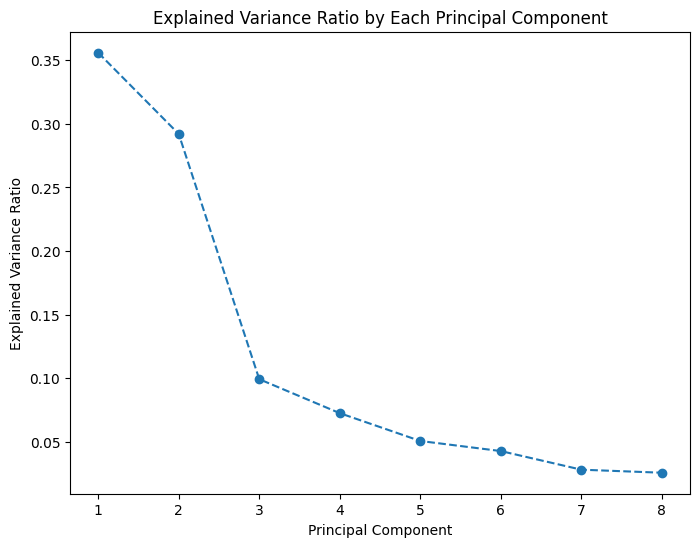

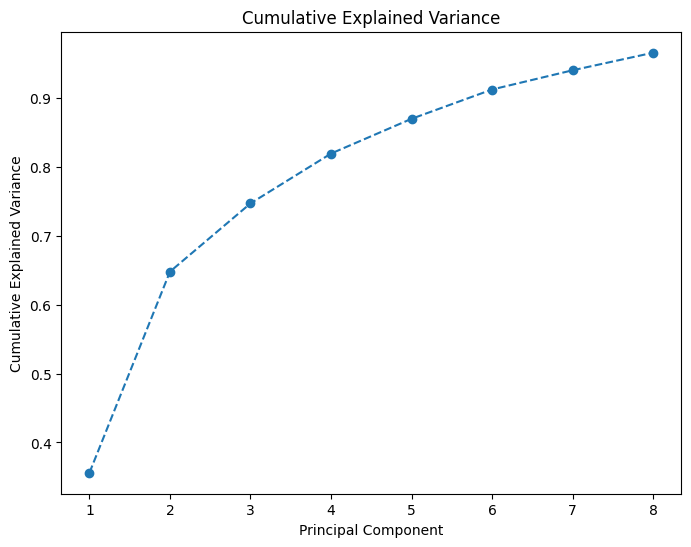

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.600961 -2.793819  0.004905  0.139702  0.201983 -0.023422  1.167264   
1 -2.119373 -2.877018 -0.102566  0.302809  0.242818  0.167390  1.197521   
2 -2.401169 -3.133403 -0.186403  0.262760  0.321254  0.239591  0.902875   
3 -2.572543 -3.450091  0.296802  0.533567  0.212998  0.086789  1.434942   
4 -2.170733 -3.351088  0.549291  0.402059  0.039801  0.017224  1.271711   

        PC8  Turn  
0 -0.758338     0  
1 -0.692912     0  
2 -0.442311     0  
3 -0.904897     0  
4 -0.968347     0  


In [ ]:
#PCA - dimensionality reduction

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the features (PCA is affected by the scale of the data)
no_label = defog_turn.drop(columns='Turn')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check the shape of the transformed data
print("Original shape:", defog_turn.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
defog_turn_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
defog_turn_pca['Turn'] = defog_turn['Turn']

# Print the first few rows of the PCA-transformed data
print(defog_turn_pca.head())

Original shape: (52762, 16)
Transformed shape: (52762, 8)


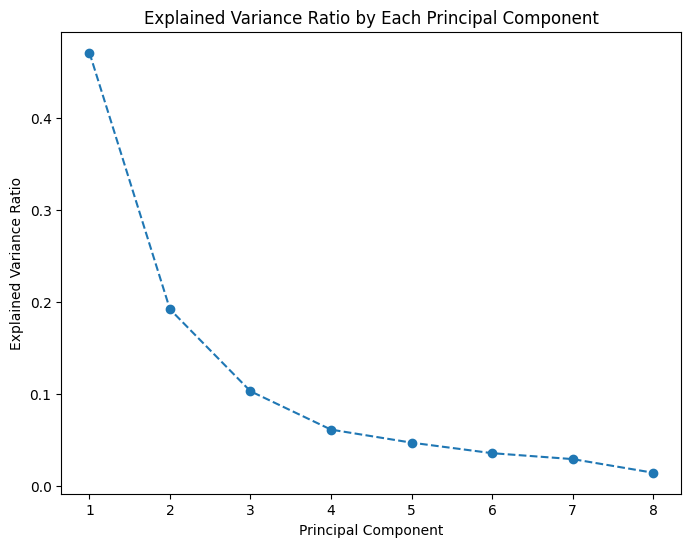

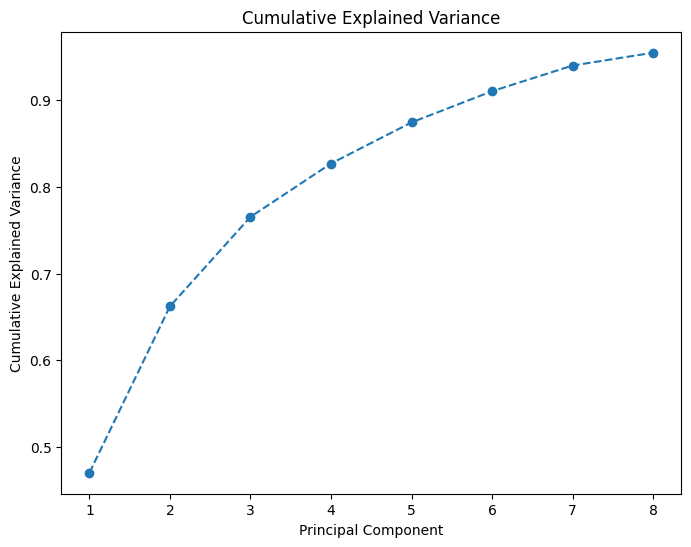

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.378735 -1.802723 -0.530801  0.080419 -0.770678 -0.730557  1.378924   
1 -3.644982 -1.700238 -0.521968 -0.551289 -0.175442 -0.931601  1.435894   
2 -4.228625 -1.406886 -0.293453 -0.515945 -0.208043 -0.567439  1.263992   
3 -4.641805 -1.403838  0.732616 -0.480616 -0.074349 -0.088438  1.071250   
4 -4.492234 -1.541033  0.152378 -0.265983 -0.218208 -0.493011  1.520999   

        PC8  Walking  
0 -1.034720        0  
1 -0.883472        0  
2 -0.370534        0  
3 -0.301259        0  
4 -0.419461        0  


In [ ]:
no_label = defog_walk.drop(columns='Walking')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", defog_walk.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
defog_walk_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
defog_walk_pca['Walking'] = defog_walk['Walking']

# Print the first few rows of the PCA-transformed data
print(defog_walk_pca.head())

Original shape: (59219, 21)
Transformed shape: (59219, 9)


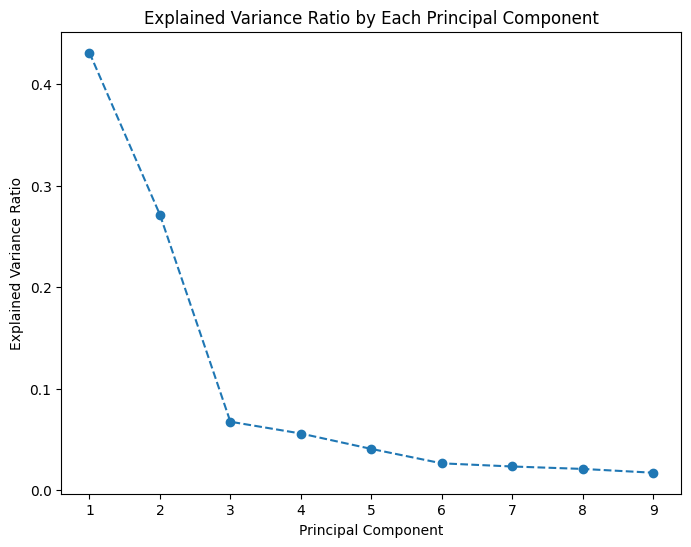

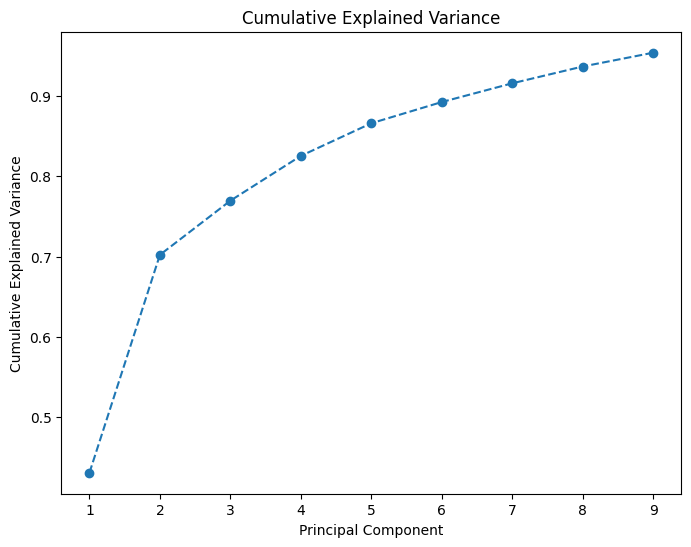

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.059010  1.274643  0.857014  1.198029 -0.536894 -1.180387 -0.080600   
1 -4.577106  2.027765 -0.131742  1.672461 -0.548473 -0.950972  0.039929   
2 -5.048827  2.250632 -0.165952  1.418399 -0.862238 -0.479996  0.341150   
3 -5.641157  2.195160 -0.308237  0.158997 -1.054277 -0.286985  0.161623   
4 -5.576318  2.078878 -0.062010  0.303962 -0.853264 -0.545008  0.167371   

        PC8       PC9  StartHesitation  
0  0.527990  0.578647                0  
1  0.746025 -0.065565                0  
2  0.901405 -0.313602                0  
3  0.121814 -0.367812                0  
4  0.432138 -0.050327                0  


In [ ]:
no_label = defog_sh.drop(columns='StartHesitation')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", defog_sh.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
defog_sh_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
defog_sh_pca['StartHesitation'] = defog_sh['StartHesitation']

# Print the first few rows of the PCA-transformed data
print(defog_sh_pca.head())

Original shape: (38134, 19)
Transformed shape: (38134, 11)


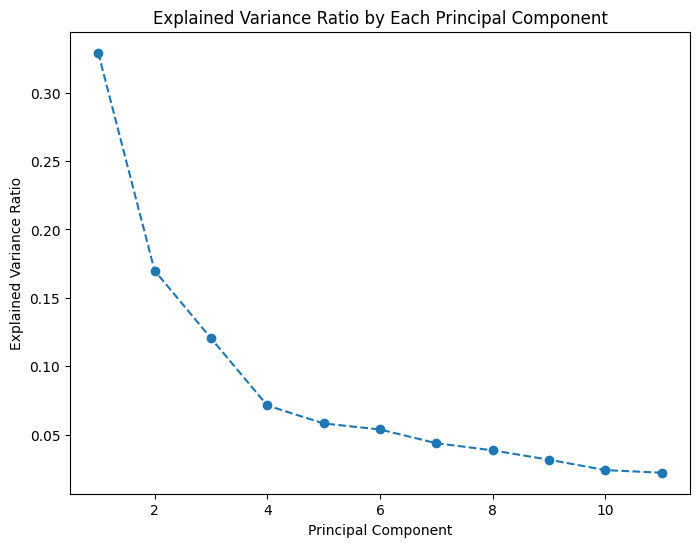

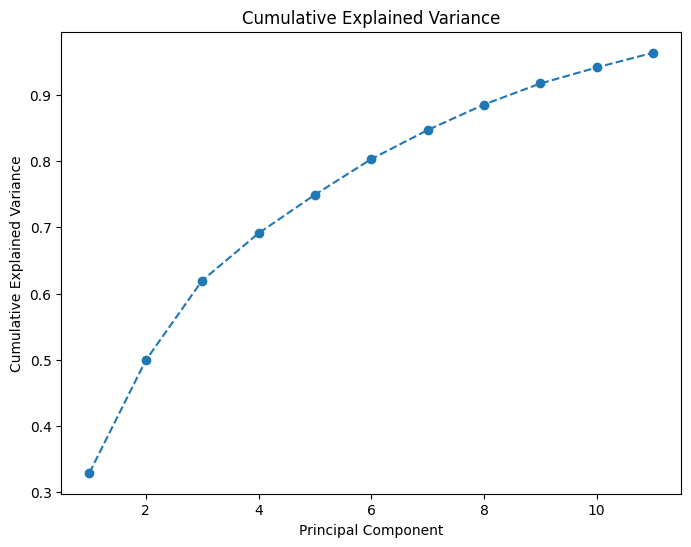

        PC1       PC2        PC3       PC4       PC5       PC6       PC7  \
0 -4.575291 -1.216096  -1.807697  0.752707  0.280635  0.822736  0.049167   
1 -4.134405 -1.158888  10.359606 -2.309619 -6.058129 -2.017016  6.876551   
2  1.273197 -3.632499   1.728155  0.630450 -0.130677  4.380849  0.641525   
3  4.900264 -5.736050   2.375001  3.431813 -1.148983  0.014466 -0.890004   
4  5.555786 -4.504202   0.960243  0.911039 -1.380766  1.252967  0.066400   

        PC8       PC9      PC10      PC11  Turn  
0  0.291946 -0.237233 -0.063425 -0.059662     0  
1 -4.569027  1.279062 -0.297603 -3.403977     0  
2  2.150764  1.572785 -0.542520  0.640963     0  
3 -2.200417 -0.924021 -0.135677 -0.079464     0  
4  0.651306 -0.621493  0.108628  0.163186     0  


In [ ]:
no_label = tdcsfog_turn.drop(columns='Turn')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", tdcsfog_turn.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
tdcsfog_turn_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
tdcsfog_turn_pca['Turn'] = tdcsfog_turn['Turn']

# Print the first few rows of the PCA-transformed data
print(tdcsfog_turn_pca.head())

Original shape: (71446, 19)
Transformed shape: (71446, 9)


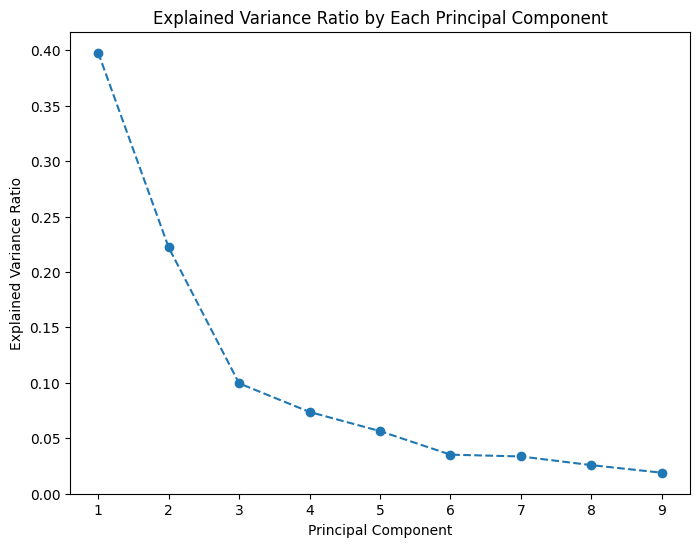

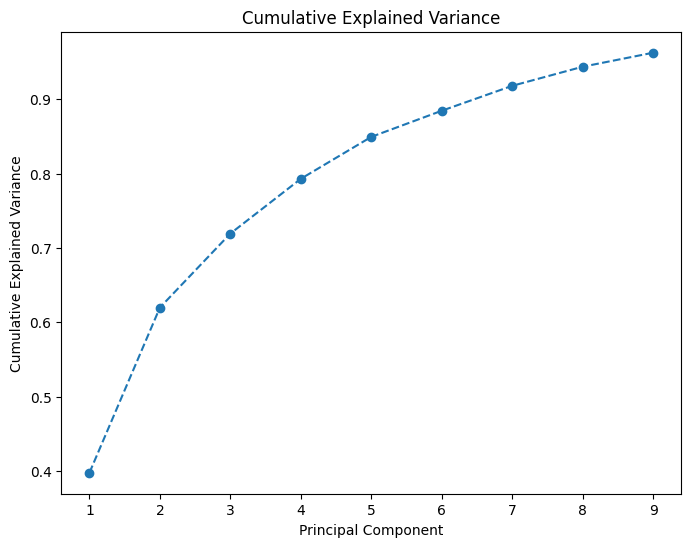

        PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.247879  -0.097532 -1.165612  2.436696 -0.262021  1.082093  0.274884   
1 -5.553067  -0.136340 -1.000857 -0.032381 -1.296749  0.438562  1.090232   
2 -3.893904   0.036037  7.640969 -5.509522  3.838897 -0.277208 -1.048617   
3  1.211217   6.674712  4.363103  1.887412 -4.531072  0.992330  3.283080   
4  4.354228  10.723066  3.400106  3.469554 -1.626458 -1.202022 -1.481853   

        PC8       PC9  Walking  
0 -0.600907  0.413652        0  
1 -0.295591 -0.166483        0  
2 -2.653751  2.308284        0  
3 -2.088028  0.638319        0  
4 -0.401704  0.062194        0  


In [ ]:
no_label = tdcsfog_walk.drop(columns='Walking')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", tdcsfog_walk.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
tdcsfog_walk_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
tdcsfog_walk_pca['Walking'] = tdcsfog_walk['Walking']

# Print the first few rows of the PCA-transformed data
print(tdcsfog_walk_pca.head())

Original shape: (67693, 17)
Transformed shape: (67693, 9)


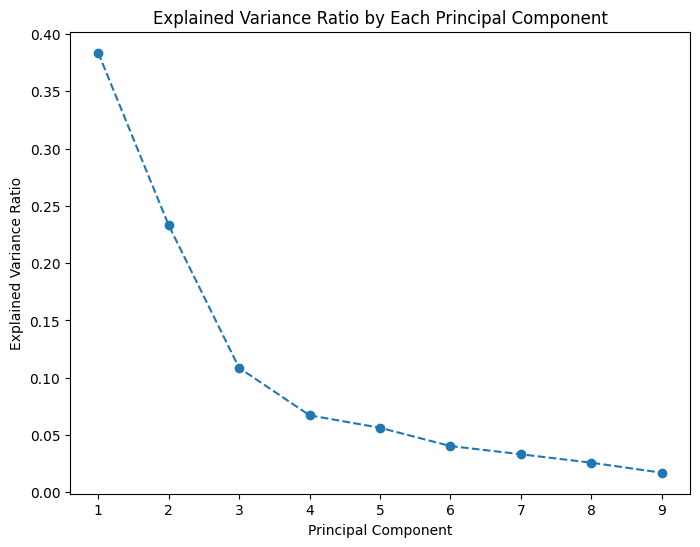

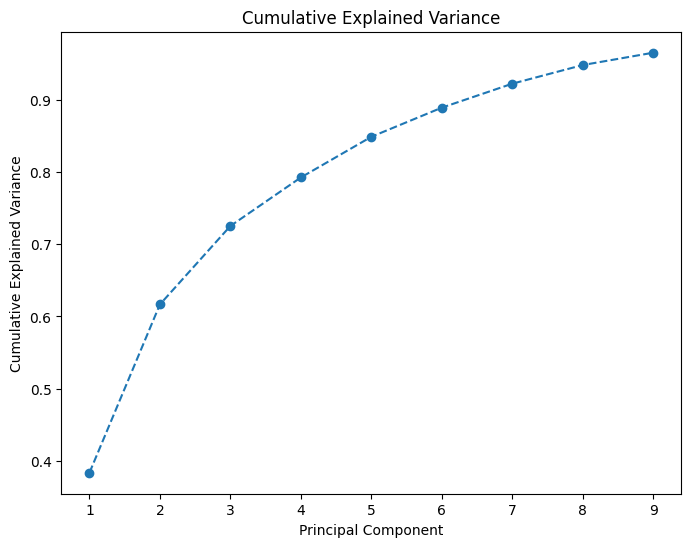

        PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0  4.764186  -0.865629 -1.333151 -1.886755 -0.884005  0.837735 -0.081551   
1  4.987792  -1.131283 -0.727673  0.436809 -1.298035  0.685444 -0.481753   
2  3.755003  -0.213232  5.455679  3.257101  2.661985 -0.336962  0.533239   
3  0.616219   7.886185  3.647964 -0.299424 -3.419059  3.289394 -0.700169   
4 -0.942910  11.252693  2.346425 -3.664034 -0.777539 -1.700630  1.499459   

        PC8       PC9  StartHesitation  
0  0.015099  0.882491                0  
1 -0.173349  0.035342                0  
2 -0.395794  0.340982                0  
3 -1.946273  0.671300                0  
4 -1.356271  0.086576                0  


In [ ]:
no_label = tdcsfog_sh.drop(columns='StartHesitation')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(no_label)

pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", tdcsfog_sh.shape)
print("Transformed shape:", X_pca.shape)

# Plot the explained variance ratio to see how much variance is explained by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# If you want to check the cumulative variance explained by the components:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Optionally, convert the PCA-transformed data back into a DataFrame
tdcsfog_sh_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
tdcsfog_sh_pca['StartHesitation'] = tdcsfog_sh['StartHesitation']

# Print the first few rows of the PCA-transformed data
print(tdcsfog_sh_pca.head())

In [ ]:
defog_turn_pca.to_csv('/content/drive/My Drive/Colab Notebooks/defog_turn.csv')
defog_walk_pca.to_csv('/content/drive/My Drive/Colab Notebooks/defog_walking.csv')
defog_sh_pca.to_csv('/content/drive/My Drive/Colab Notebooks/defog_start_hesitation.csv')

tdcsfog_turn_pca.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_turn.csv')
tdcsfog_walk_pca.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_walking.csv')
tdcsfog_sh_pca.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_start_hesitation.csv')

In [ ]:
defog_turn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/defog_turn_test_draft.csv')
defog_walk_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/defog_walk_test_draft.csv')
defog_sh_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/defog_sh_test_draft.csv')

tdcsfog_turn_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_turn_test_draft.csv')
tdcsfog_walk_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_walk_test_draft.csv')
tdcsfog_sh_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_sh_test_draft.csv')

In [ ]:
# Remove the label column from the test data
no_label_test = defog_turn_test.drop(columns='Turn')

# Scale the test data using the trained scaler
X_test_scaled = scaler.transform(no_label_test)

# Apply the trained PCA to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", defog_turn_test.shape)
print("Transformed shape:", X_test_pca.shape)

# Convert the PCA-transformed test data back into a DataFrame
defog_turn_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Add the label column back to the transformed test data
defog_turn_test_pca['Turn'] = defog_turn_test['Turn']

# Print the first few rows of the PCA-transformed test data
print(defog_turn_test_pca.head())


Original shape: (1285, 14)
Transformed shape: (1285, 8)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.555009  0.605341  1.105841 -0.823493  1.192553 -0.479055 -0.196930   
1  2.793167  2.743366  4.175451  0.151046  4.269899  0.440288 -1.223716   
2  2.637888  3.070655  4.657617 -0.129254  4.362733  1.197715 -1.148918   
3  2.432217  3.473734  5.213388 -0.596030  4.354215  2.203714 -0.983010   
4  3.851895  0.066528  0.416283  0.852514 -0.158217 -0.132188  0.016618   

        PC8  Turn  
0 -0.168055     0  
1 -0.689433     0  
2 -0.840174     0  
3 -1.017766     0  
4  0.146432     0  


In [ ]:
# Remove the label column from the test data
no_label_test = defog_walk_test.drop(columns='Walking')

# Scale the test data using the trained scaler
X_test_scaled = scaler.transform(no_label_test)

# Apply the trained PCA to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", defog_walk_test.shape)
print("Transformed shape:", X_test_pca.shape)

# Convert the PCA-transformed test data back into a DataFrame
defog_walk_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Add the label column back to the transformed test data
defog_walk_test_pca['Walking'] = defog_walk_test['Walking']

# Print the first few rows of the PCA-transformed test data
print(defog_walk_test_pca.head())

Original shape: (1285, 16)
Transformed shape: (1285, 8)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  4.317413  0.036561 -0.900469 -2.189015  0.545232  0.356858  0.436013   
1  4.171481 -0.183856 -1.363225  1.152901  3.088963 -1.670770  0.855470   
2  4.122440  0.057086 -1.684743  2.061214  4.117958 -2.097520  1.165311   
3  4.053525  0.490108 -2.142500  3.149641  5.438940 -2.559314  1.597471   
4  4.455383 -1.215061 -0.306904 -0.120664 -0.061240  0.159117  0.027453   

        PC8  Walking  
0 -0.013556        0  
1  0.272183        0  
2  0.348128        0  
3  0.438389        0  
4 -0.036245        0  


In [ ]:
# Remove the label column from the test data
no_label_test = defog_sh_test.drop(columns='StartHesitation')

# Scale the test data using the trained scaler
X_test_scaled = scaler.transform(no_label_test)

# Apply the trained PCA to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", defog_sh.shape)
print("Transformed shape:", X_pca.shape)

# Convert the PCA-transformed test data back into a DataFrame
defog_sh_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Add the label column back to the transformed test data
defog_sh_test_pca['StartHesitation'] = defog_sh_test['StartHesitation']

# Print the first few rows of the PCA-transformed test data
print(defog_sh_test_pca.head())

Original shape: (59219, 21)
Transformed shape: (59219, 9)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.313357 -4.829104  2.392809  0.028873  2.165882 -0.407373 -1.959504   
1  1.357555 -5.282229  7.645303 -2.222367  2.396701  3.019351 -6.510466   
2  1.340869 -5.324422  7.800140 -2.263039  2.473429  3.227321 -6.381532   
3  1.491355 -5.102322  8.027849 -2.627981  2.091303  3.327912 -6.068595   
4  1.424275 -4.460011 -0.585877 -0.267356 -1.009208  0.171141  0.003498   

        PC8       PC9  StartHesitation  
0  0.226371 -1.731990                0  
1  4.193600 -1.442188                0  
2  4.779586 -1.126791                0  
3  5.054568 -0.642115                0  
4  1.036394 -0.239722                0  


In [ ]:
# Remove the label column from the test data
no_label_test = tdcsfog_turn_test.drop(columns='Turn')

# Scale the test data using the trained scaler
X_test_scaled = scaler.transform(no_label_test)

# Apply the trained PCA to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", tdcsfog_turn_test.shape)
print("Transformed shape:", X_test_pca.shape)

# Convert the PCA-transformed test data back into a DataFrame
tdcsfog_turn_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Add the label column back to the transformed test data
tdcsfog_turn_test_pca['Turn'] = tdcsfog_turn_test['Turn']

# Print the first few rows of the PCA-transformed test data
print(tdcsfog_turn_test_pca.head())


Original shape: (361, 19)
Transformed shape: (361, 11)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -4.558912 -1.000608 -1.765410  2.122753 -0.241944  0.292201  0.419245   
1 -4.647095 -1.048617 -1.774725  0.741855 -2.093442  0.229779  0.345273   
2 -4.480709 -0.513812 -0.151037 -2.338474 -0.767987  0.692800 -1.486679   
3 -2.268821 -1.633956  6.019846 -0.847439 -4.754025  0.254469  4.371624   
4 -1.272433 -1.629377  2.210315 -0.012712 -3.717975  1.909234  1.361762   

        PC8       PC9      PC10      PC11  Turn  
0  0.694119 -0.361050  0.554839  0.675398     0  
1  0.484747 -0.076419 -0.181674 -0.074356     0  
2  0.330577 -0.064136  0.703188  0.103165     0  
3 -1.515853  2.440839 -0.347977 -2.996380     0  
4 -0.633799  1.421364 -0.883695 -1.179016     0  


In [ ]:
# Remove the label column from the test data
no_label_test = tdcsfog_walk_test.drop(columns='Walking')

# Scale the test data using the trained scaler
X_test_scaled = scaler.transform(no_label_test)

# Apply the trained PCA to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", tdcsfog_walk_test.shape)
print("Transformed shape:", X_test_pca.shape)

# Convert the PCA-transformed test data back into a DataFrame
tdcsfog_walk_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Add the label column back to the transformed test data
tdcsfog_walk_test_pca['Walking'] = tdcsfog_walk_test['Walking']

# Print the first few rows of the PCA-transformed test data
print(tdcsfog_walk_test_pca.head())

Original shape: (361, 19)
Transformed shape: (361, 9)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -5.323772 -0.003925 -1.072463  2.504091  0.163969  0.973779  0.235721   
1 -5.506546  0.027250 -1.253309  0.937572 -1.036939  0.334648  0.488285   
2 -4.989670 -0.825342  1.130794 -1.923538 -1.550589 -0.246075  0.087627   
3 -2.409238  1.761802  4.071607 -2.063834 -0.411514 -0.254477  2.151966   
4 -1.547210  2.486314  2.351423  0.004478 -3.110257 -0.046188  1.411215   

        PC8       PC9  Walking  
0 -0.298644  0.581682        0  
1 -0.432269 -0.113006        0  
2  1.123411  0.648512        0  
3 -0.716654  0.334372        0  
4 -0.831943 -0.160770        0  


In [ ]:
# Remove the label column from the test data
no_label_test = tdcsfog_sh_test.drop(columns='StartHesitation')

# Scale the test data using the trained scaler
X_test_scaled = scaler.transform(no_label_test)

# Apply the trained PCA to the scaled test data
X_test_pca = pca.transform(X_test_scaled)

print("Original shape:", tdcsfog_sh.shape)
print("Transformed shape:", X_pca.shape)

# Convert the PCA-transformed test data back into a DataFrame
tdcsfog_sh_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Add the label column back to the transformed test data
tdcsfog_sh_test_pca['StartHesitation'] = tdcsfog_sh_test['StartHesitation']

# Print the first few rows of the PCA-transformed test data
print(tdcsfog_sh_test_pca.head())


Original shape: (67693, 17)
Transformed shape: (67693, 9)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  4.870462 -0.847211 -1.284947 -2.036051 -0.490770  0.630237 -0.229059   
1  4.948565 -0.968741 -1.115141 -0.565309 -1.244728  0.449263 -0.133422   
2  4.336785 -1.624595  1.582765  1.689943 -1.133115 -0.776466 -0.248941   
3  2.784089  1.650584  3.864894  2.166829  0.579356  1.209838 -1.129296   
4  2.023365  2.620777  2.294881  0.587011 -2.401552  1.142712 -0.300051   

        PC8       PC9  StartHesitation  
0  0.220880  1.025428                0  
1 -0.227866  0.287640                0  
2  0.152359  0.112787                0  
3 -0.823494 -0.046344                0  
4 -1.206017  0.091589                1  


In [ ]:
defog_turn_test_pca.to_csv('/content/drive/My Drive/Colab Notebooks/defog_turn_test.csv')
defog_walk_test_pca.to_csv('/content/drive/My Drive/Colab Notebooks/defog_walking_test.csv')
defog_sh_test_pca.to_csv('/content/drive/My Drive/Colab Notebooks/defog_start_hesitation_test.csv')

tdcsfog_turn_test_pca.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_turn_test.csv')
tdcsfog_walk_test_pca.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_walking_test.csv')
tdcsfog_sh_test_pca.to_csv('/content/drive/My Drive/Colab Notebooks/tdcsfog_start_hesitation_test.csv')